# Environment Module - LocalDescriptors
The `freud.environment` module analyzes the local environments of particles. The `freud.environment.LocalDescriptors` class is a useful tool for analyzing identifying crystal structures in a rotationally invariant manner using local particle environments. The primary purpose of this class is to compute spherical harmonics between neighboring particles in a way that orients particles correctly relative to their local environment, ensuring that global orientational shifts do not change the output.

In [1]:
import freud
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import util
%matplotlib notebook

For simplicity, we consider points on a simple cubic lattice, with a little bit of noise.

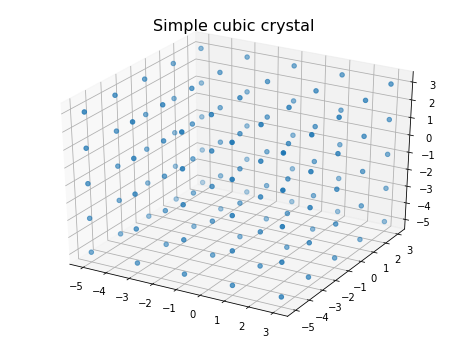

In [14]:
box, points = util.make_sc(5, 5, 5)
orientations = np.array([[1, 0, 0, 0]], dtype=np.float32).repeat(points.shape[0], axis=0)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_title("Simple cubic crystal", fontsize=16);

Now, let's use the class to compute an array of spherical harmonics for the system.
The harmonics are computed for each bond, where a bond is defined by a pair of particles that are determined to lie within each others' nearest neighbor shells based on a standard neighbor list search.
The number of bonds and spherical harmonics to calculate is configurable.

In [3]:
num_neighbors = 6
l_max = 12
r_max = 2

# In order to be able to access information on which particles are bonded
# to which ones, we precompute the neighborlist
nn = freud.locality.NearestNeighbors(r_max, num_neighbors)
nn.compute(box, points)
nl = nn.nlist
ld = freud.environment.LocalDescriptors(num_neighbors, l_max, r_max)
ld.compute(box, num_neighbors, points, orientations=orientations, mode='global', nlist=nl);

The resulting spherical harmonic array has a shape corresponding to the number of neighbors.
We can now extract the spherical harmonics corresponding to a particular $(l, m)$ pair using the ordering used by the LocalDescriptors class: increasing values of $l$, and for each $l$, the nonnegative $m$ values followed by the negative values.

In [4]:
sph_raw = np.mean(ld.sph, axis=0)
count = 0
sph = np.zeros((l_max+1, l_max+1), dtype=np.complex128)
for l in range(l_max+1):
    for m in range(l+1):
        sph[l, m] = sph_raw[count]
        count += 1
    for m in range(-l, 0):
        sph[l, m] = sph_raw[count]
        count += 1

We can also use these spherical harmonics to try and calculate various quantities to describe our system.
For example, we could use these to compute the Steinhardt order parameters.

In [5]:
Qbar_lm = np.zeros((points.shape[0], ld.sph.shape[1]), dtype=np.complex128)
for i in range(points.shape[0]):
    indices = nl.index_i == i
    Qbar_lm[i, :] = np.sum(ld.sph[indices, :], axis=0)/num_neighbors

Ql = np.zeros((Qbar_lm.shape[0], l_max+1))
for i in range(Ql.shape[0]):
    for l in range(Ql.shape[1]):
        for k in range(l**2, (l+1)**2):
            Ql[i, l] += np.absolute(Qbar_lm[l, k])**2
        Ql[i, l] = np.sqrt(4*np.pi/(2*l + 1) * Ql[i, l])

Since `freud` provides the ability to calculate these parameter as well, we can directly check that our answers are correct.

In [9]:
L = 6
ql = freud.order.LocalQl(box, r_max*2, L, 0)
ql.compute(points, nl)
print(np.allclose(ql.Ql, Ql[:, L]))

True
